In [1]:
# Core libraries
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    precision_recall_curve,
    accuracy_score
)
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    FunctionTransformer,
    KBinsDiscretizer
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv(r'C:\Users\hmadarw\Learnings\DataScience\Projects\CustomerChurn\churn.csv')

# Drop ID columns
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Separate features and target
X = df.drop(columns=['Exited'])
y = df['Exited']

print(f"Dataset: {X.shape[0]} rows, {X.shape[1]} features")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nTarget distribution:")
print(f"  Retained (0): {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
print(f"  Churned (1): {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")
print(f"  Imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1")

Dataset: 10000 rows, 10 features

Features: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

Target distribution:
  Retained (0): 7963 (79.6%)
  Churned (1): 2037 (20.4%)
  Imbalance ratio: 3.9:1


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Training: 8000 samples
Test: 2000 samples


In [4]:
# Columns to transform
NUMERIC_STANDARD = ['CreditScore']
NUMERIC_ROBUST = ['Age']  # Has outliers -> RobustScaler
NUMERIC_LOG = ['Balance']  # Skewed -> log transform
CATEGORICAL = ['Geography', 'Gender']
CATEGORICAL_SPECIAL = ['NumOfProducts']  # Non-linear relationship
BINARY = ['IsActiveMember']

# Columns to drop (no signal from EDA)
DROP_COLUMNS = ['Tenure', 'EstimatedSalary', 'HasCrCard']

print("Column groups defined.")

Column groups defined.


In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        # Standard scaling
        ('num_standard', StandardScaler(), NUMERIC_STANDARD),

        # Robust scaling for Age (handles outliers)
        ('num_robust', RobustScaler(), NUMERIC_ROBUST),

        # Binning for Age (captures non-linear relationship)
        ('age_bins', KBinsDiscretizer(
            n_bins=5,
            encode='onehot-dense',
            strategy='quantile'
        ), NUMERIC_ROBUST),

        # Log transform for Balance
        ('num_log', Pipeline([
            ('log1p', FunctionTransformer(
                np.log1p,
                validate=True,
                feature_names_out='one-to-one'
            )),
            ('scale', StandardScaler())
        ]), NUMERIC_LOG),

        # One-hot encoding
        ('cat', OneHotEncoder(
            drop='first',
            sparse_output=False,
            handle_unknown='ignore'
        ), CATEGORICAL),

        # NumOfProducts (one-hot, non-linear relationship)
        ('products', OneHotEncoder(
            sparse_output=False,
            handle_unknown='ignore'
        ), CATEGORICAL_SPECIAL),

        # Pass through binary
        ('binary', 'passthrough', BINARY),

        # Drop low-signal columns
        ('drop', 'drop', DROP_COLUMNS)
    ],
    remainder='drop'
)

print("ColumnTransformer built.")

ColumnTransformer built.


In [6]:
preprocessor.transformers[0]

('num_standard', StandardScaler(), ['CreditScore'])

In [7]:
# Fit on training, transform both
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Preprocessed shape: {X_train_preprocessed.shape}")
print(f"\nFeature names:")
for name in preprocessor.get_feature_names_out():
    print(f"  - {name}")

Preprocessed shape: (8000, 16)

Feature names:
  - num_standard__CreditScore
  - num_robust__Age
  - age_bins__Age_0.0
  - age_bins__Age_1.0
  - age_bins__Age_2.0
  - age_bins__Age_3.0
  - age_bins__Age_4.0
  - num_log__Balance
  - cat__Geography_Germany
  - cat__Geography_Spain
  - cat__Gender_Male
  - products__NumOfProducts_1
  - products__NumOfProducts_2
  - products__NumOfProducts_3
  - products__NumOfProducts_4
  - binary__IsActiveMember


In [8]:
np.maximum(df['NumOfProducts'].values,1)

array([1, 1, 3, ..., 1, 2, 1], shape=(10000,))

In [9]:
def create_custom_features(X_df):
    """
    Create custom features from original data.
    Based on EDA insights and lift analysis.
    """
    features = pd.DataFrame(index=range(len(X_df)))

    # Binary Flags
    features['HasBalance'] = (X_df['Balance'].values > 0).astype(int)
    features['IsSenior'] = (X_df['Age'].values > 50).astype(int)
    features['Has3PlusProducts'] = (X_df['NumOfProducts'].values >= 3).astype(int)
    features['IsInactive'] = (X_df['IsActiveMember'].values == 0).astype(int)
    features['IsGermany'] = (X_df['Geography'].values == 'Germany').astype(int)
    features['IsFemale'] = (X_df['Gender'].values == 'Female').astype(int)

    # Interactions (high-risk segments)
    features['Germany_Female'] = features['IsGermany'] * features['IsFemale']
    features['Senior_Inactive'] = features['IsSenior'] * features['IsInactive']
    features['Germany_Senior'] = features['IsGermany'] * features['IsSenior']

    # Log transform for Age (better than Age²)
    features['Age_Log'] = np.log1p(X_df['Age'].values)

    # Ratio feature
    num_products = np.maximum(X_df['NumOfProducts'].values, 1)
    features['BalancePerProduct'] = X_df['Balance'].values / num_products

    # Risk Score (weights from lift analysis)
    RISK_WEIGHTS = {
        'IsGermany': 1.6,
        'IsFemale': 1.2,
        'IsInactive': 1.3,
        'IsSenior': 1.5,
        'Has3PlusProducts': 4.2,
        'Senior_Inactive': 2.0
    }

    features['RiskScore'] = (
        features['IsGermany'] * RISK_WEIGHTS['IsGermany'] +
        features['IsFemale'] * RISK_WEIGHTS['IsFemale'] +
        features['IsInactive'] * RISK_WEIGHTS['IsInactive'] +
        features['IsSenior'] * RISK_WEIGHTS['IsSenior'] +
        features['Has3PlusProducts'] * RISK_WEIGHTS['Has3PlusProducts'] +
        features['Senior_Inactive'] * RISK_WEIGHTS['Senior_Inactive']
    )

    return features


# Create custom features
custom_train = create_custom_features(X_train)
custom_test = create_custom_features(X_test)

print(f"Custom features: {list(custom_train.columns)}")

Custom features: ['HasBalance', 'IsSenior', 'Has3PlusProducts', 'IsInactive', 'IsGermany', 'IsFemale', 'Germany_Female', 'Senior_Inactive', 'Germany_Senior', 'Age_Log', 'BalancePerProduct', 'RiskScore']


In [10]:
# Scale continuous custom features
CONTINUOUS_CUSTOM = ['Age_Log', 'BalancePerProduct', 'RiskScore']

custom_scaler = StandardScaler()
custom_train[CONTINUOUS_CUSTOM] = custom_scaler.fit_transform(custom_train[CONTINUOUS_CUSTOM])
custom_test[CONTINUOUS_CUSTOM] = custom_scaler.transform(custom_test[CONTINUOUS_CUSTOM])

print(f"Scaled: {CONTINUOUS_CUSTOM}")

Scaled: ['Age_Log', 'BalancePerProduct', 'RiskScore']


In [11]:
custom_train.values

array([[ 0.        ,  1.        ,  0.        , ...,  1.60963234,
        -1.10656936,  1.65687256],
       [ 1.        ,  0.        ,  0.        , ..., -0.63056283,
         0.69294524,  0.53734914],
       [ 1.        ,  0.        ,  0.        , ..., -0.07013771,
        -0.10340861,  0.47842686],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.07013771,
        -0.47412168, -0.4643297 ],
       [ 1.        ,  0.        ,  0.        , ..., -0.28491606,
        -0.21685449, -0.40540742],
       [ 0.        ,  1.        ,  0.        , ...,  1.17584559,
        -1.10656936, -0.28756285]], shape=(8000, 12))

In [12]:
# Combine preprocessed + custom
X_train_final = np.hstack([X_train_preprocessed, custom_train.values])
X_test_final = np.hstack([X_test_preprocessed, custom_test.values])


# Feature names
all_feature_names = list(preprocessor.get_feature_names_out()) + list(custom_train.columns)

print(f"Final shape: {X_train_final.shape}")
print(f"Total features: {len(all_feature_names)}")

Final shape: (8000, 28)
Total features: 28


In [13]:
y_train.shape

(8000,)

In [14]:
final_corr_df = pd.concat([pd.DataFrame(X_train_final, columns=all_feature_names).reset_index(
    drop=True), pd.DataFrame(y_train, columns=['Exited']).reset_index(
    drop=True)], axis=1).corr()

In [15]:
final_corr_df['Exited'].sort_values(ascending=False)

Exited                       1.000000
RiskScore                    0.448425
Senior_Inactive              0.341624
age_bins__Age_4.0            0.318609
Has3PlusProducts             0.295035
Age_Log                      0.290066
num_robust__Age              0.280378
products__NumOfProducts_3    0.249862
IsSenior                     0.227196
products__NumOfProducts_1    0.192151
Germany_Senior               0.188843
cat__Geography_Germany       0.182234
IsGermany                    0.182234
Germany_Female               0.160629
products__NumOfProducts_4    0.156775
IsInactive                   0.152286
num_log__Balance             0.126858
HasBalance                   0.126643
BalancePerProduct            0.115403
IsFemale                     0.105920
age_bins__Age_3.0            0.057810
num_standard__CreditScore   -0.033998
cat__Geography_Spain        -0.054385
age_bins__Age_2.0           -0.098557
cat__Gender_Male            -0.105920
age_bins__Age_1.0           -0.133048
binary__IsAc

<Axes: >

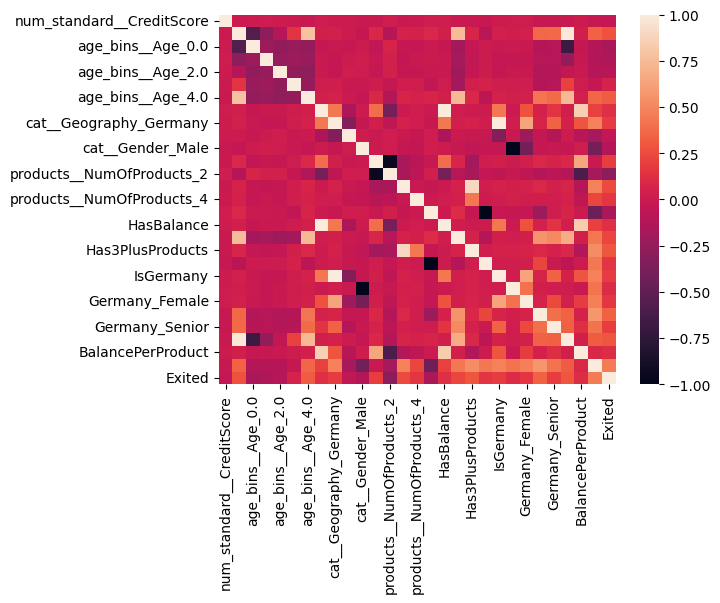

In [16]:
sns.heatmap(final_corr_df)

# PCA

In [17]:
corr_matrix = np.corrcoef(X_train_final.T)

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)

In [19]:
X_pca = pca.fit_transform(X_train_final)

In [20]:
 pca.explained_variance_ratio_

array([2.71302079e-01, 2.22597728e-01, 1.25561352e-01, 1.08602003e-01,
       5.48169095e-02, 5.17054682e-02, 3.38216096e-02, 2.73138076e-02,
       2.33438667e-02, 1.92736362e-02, 1.79799494e-02, 1.52413787e-02,
       1.01661199e-02, 5.57318811e-03, 4.39157013e-03, 3.00641898e-03,
       2.26370315e-03, 1.44720207e-03, 1.02199943e-03, 5.55724050e-04,
       1.42863310e-05, 2.76449300e-17, 9.56232400e-18, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

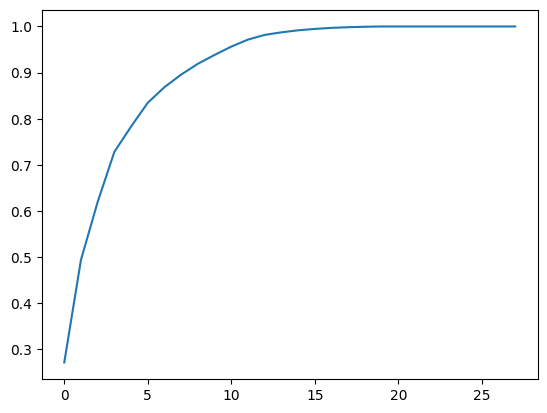

In [21]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Reasons:                                                             │
│  1. Tree-based models don't benefit from PCA                       │
│  2. Our features are already low-dimensional (18)                  │
│  3. We'd lose interpretability of business features                │
│  4. Results show no improvement (or slight degradation)            │
│  5. Binary features don't work well with PCA                       │
│                                                                    │

In [23]:
X_train_final.shape

(8000, 28)

In [25]:
X_test_final.shape

(2000, 28)

In [29]:
pd.DataFrame(X_train_final).to_csv("X_train_final_fe.csv", index=False)
pd.DataFrame(X_test_final).to_csv("X_test_final_fe.csv", index=False)
pd.DataFrame(y_train).to_csv("y_train_final.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_final.csv", index=False)

In [22]:
# Define models with class_weight='balanced'
models = {
    'LogisticRegression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        random_state=42
    )
}

# Train and evaluate
results = []
model_outputs = {}
for name, model in models.items():
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    y_proba = model.predict_proba(X_test_final)[:, 1]
    
    # Store everything in a dict
    model_outputs[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_proba": y_proba,
    }
    results.append({
        'Model': name,
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'F1': f1_score(y_test, y_pred),
        'accuracy_score': accuracy_score(y_test, y_pred),
    })

# Display results
results_df = pd.DataFrame(results)
print("Model Comparison (with class_weight='balanced'):")
print(results_df.to_string(index=False))

NameError: name 'AdaBoostClassifier' is not defined

In [ ]:
model_outputs

{'LogisticRegression': {'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
  'y_pred': array([0, 0, 0, ..., 1, 0, 0], shape=(2000,)),
  'y_proba': array([0.1196538 , 0.2421097 , 0.24275453, ..., 0.94028098, 0.10884576,
         0.2333712 ], shape=(2000,))},
 'RandomForest': {'model': RandomForestClassifier(class_weight='balanced', random_state=42),
  'y_pred': array([0, 0, 0, ..., 1, 0, 0], shape=(2000,)),
  'y_proba': array([0.  , 0.03, 0.17, ..., 0.92, 0.  , 0.48], shape=(2000,))},
 'GradientBoosting': {'model': GradientBoostingClassifier(random_state=42),
  'y_pred': array([0, 0, 0, ..., 1, 0, 0], shape=(2000,)),
  'y_proba': array([0.02597288, 0.05362775, 0.04575611, ..., 0.82847506, 0.02852656,
         0.07292368], shape=(2000,))},
 'AdaBoost': {'model': AdaBoostClassifier(n_estimators=100, random_state=42),
  'y_pred': array([0, 0, 0, ..., 1, 0, 0], shape=(2000,)),
  'y_proba': array([0.29100696, 0.32116316, 0.30345425, ..., 0.53669799, 0.30345

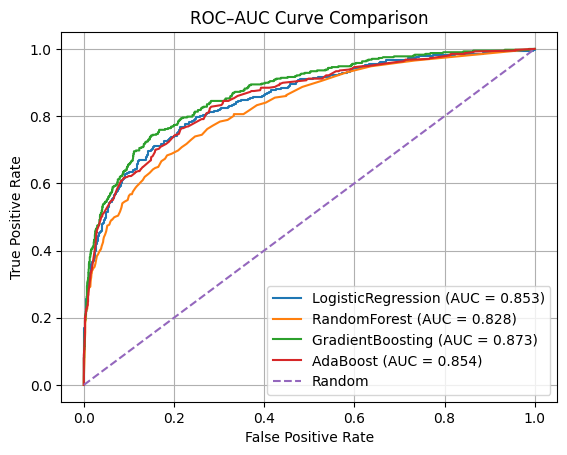

In [ ]:
for name, output in model_outputs.items():
    y_proba = output["y_proba"]

    if y_proba is None:
        logger.warning("Skipping ROC curve for %s (no probabilities)", name)
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Best model
best_model = models['GradientBoosting']
y_pred = best_model.predict(X_test_final)

print("Best Model: GradientBoosting")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))

Best Model: GradientBoosting

Classification Report:
              precision    recall  f1-score   support

    Retained       0.88      0.97      0.92      1593
     Churned       0.79      0.48      0.59       407

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000



In [ ]:
# Check Multicollinearrity
# !pip install statsmodels


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
final_corr_df = pd.concat([pd.DataFrame(X_train_final, columns=all_feature_names).reset_index(
    drop=True), pd.DataFrame(y_train, columns=['Exited']).reset_index(
    drop=True)], axis=1)

In [ ]:
final_corr_df.head()

,num_standard__CreditScore,num_robust__Age,age_bins__Age_0.0,age_bins__Age_1.0,age_bins__Age_2.0,age_bins__Age_3.0,age_bins__Age_4.0,num_log__Balance,cat__Geography_Germany,cat__Geography_Spain,...,IsInactive,IsGermany,IsFemale,Germany_Female,Senior_Inactive,Germany_Senior,Age_Log,BalancePerProduct,RiskScore,Exited
0,1.058568,1.666667,0.0,0.0,0.0,0.0,1.0,-1.328266,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.609632,-1.106569,1.656873,1
1,0.913626,-0.416667,0.0,1.0,0.0,0.0,0.0,0.729917,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,-0.630563,0.692945,0.537349,1
2,1.079274,0.000000,0.0,0.0,1.0,0.0,0.0,0.749329,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,-0.070138,-0.103409,0.478427,0
3,-0.929207,0.000000,0.0,0.0,1.0,0.0,0.0,-1.328266,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,-0.070138,-1.106569,-0.405407,0
4,0.427035,1.000000,0.0,0.0,0.0,0.0,1.0,0.744041,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.020044,-0.132700,-0.228641,0


In [ ]:
vif = []
for i in range(final_corr_df.shape[1]):
    vif.append(variance_inflation_factor(final_corr_df, i))

In [ ]:
pd.DataFrame({'vif':vif})

,vif
0,1.003221
1,77.343659
2,inf
3,inf
4,inf
5,inf
6,inf
7,1556.906091
8,inf
9,1.127981


In [ ]:
X_train_final.corr()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'